In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as mp
np.random.seed(100)


# Using cvxopt library to solve the optimization problem of SVM

In [48]:
from cvxopt import matrix, solvers

In [49]:
x = np.random.uniform(low =0, high = 1, size=(100,2))

In [50]:
d =[]
colors =[]
for i in range(len(x)):
    if (x[i][1] < 0.2*(np.sin(10*x[i][0])) + 0.3) or ((x[i][1] - 0.8)**2 + (x[i][0]-0.5)**2 < 0.0225):
        d.append(1)
        colors.append("r")
    else:
        d.append(-1)
        colors.append("b")
d = np.asarray(d)        

In [51]:
d.reshape(1,-1).shape


(1, 100)

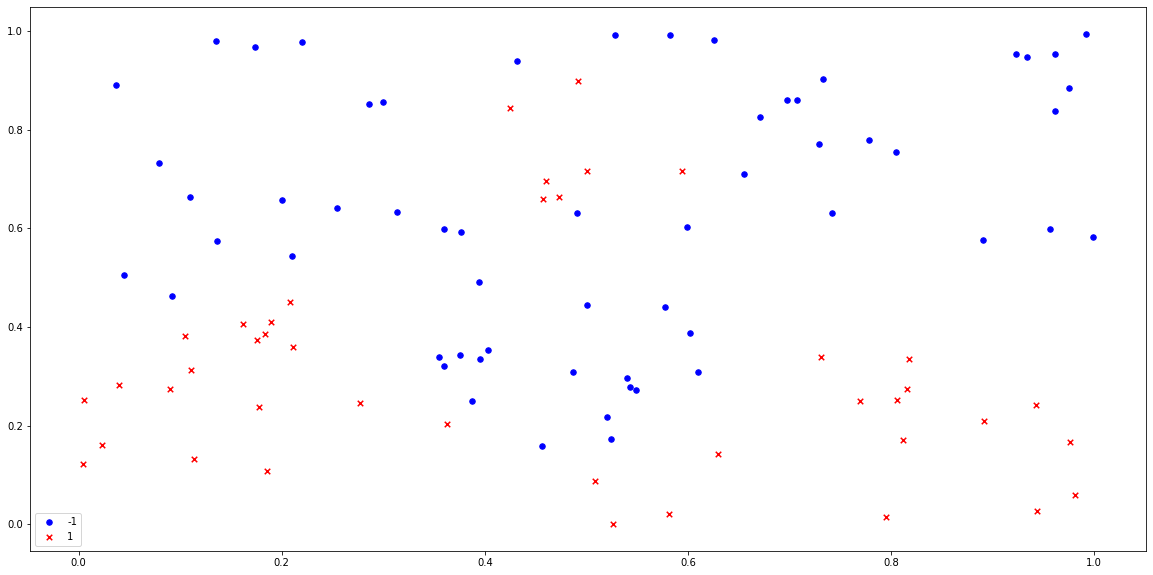

In [52]:
fig, ax = mp.subplots(figsize = (20,10))
cdict = {1: 'red', -1: 'blue'}
markers = {1:'x', -1:'o'}
for g in np.unique(d):
    ix = np.where(d == g)
    ax.scatter(x[:,0][ix], x[:,1][ix], c = cdict[g],marker = markers[g],label = g, s = 30)
    
ax.legend(loc = 'lower left')

# Kernel Function

# I am using a polynomial kernel of degree 3

In [62]:
def kernel(X, Y):
#     K = np.zeros((X.shape[0], Y.shape[0]))

#     for i, x in enumerate(X):
#         for j, y in enumerate(Y):
#             K[i, j] = np.exp(-0.5*np.linalg.norm(x - y) ** 2)
        
    return (1+X.dot(Y.T))**3

# Finding Alpha values using cvxopt library to solve the optimization problem of SVM

In [63]:
def train_svm():
    n, k = x.shape    
    y_matrix = d.reshape(1, -1) * 1.
    H = np.dot(y_matrix.T, y_matrix) * kernel(x, x)
    P = matrix(H)
    q = matrix(-np.ones((n, 1)))
    G = matrix(np.diag(np.ones(n) * -1))
    h = matrix(np.zeros(n))
    A = matrix(y_matrix)
    b = matrix(np.zeros(1))
    
#     solvers.options['abstol'] = 1e-10
#     solvers.options['reltol'] = 1e-10
#     solvers.options['feastol'] = 1e-10

    return solvers.qp(P, q, G, h, A, b)

In [64]:
parameters = train_svm()

     pcost       dcost       gap    pres   dres
 0: -6.4862e+01 -1.9051e+02  4e+02  1e+01  3e+00
 1: -2.3482e+02 -3.8691e+02  2e+02  6e+00  2e+00
 2: -3.1394e+02 -4.9169e+02  2e+02  5e+00  1e+00
 3: -5.3124e+02 -7.5929e+02  3e+02  5e+00  1e+00
 4: -1.4735e+03 -1.7590e+03  3e+02  4e+00  1e+00
 5: -2.1726e+03 -2.5225e+03  4e+02  4e+00  1e+00
 6: -6.5390e+03 -7.2515e+03  7e+02  4e+00  1e+00
 7: -2.8736e+04 -3.0840e+04  2e+03  4e+00  1e+00
 8: -5.0928e+04 -5.4486e+04  4e+03  4e+00  1e+00
 9: -1.1426e+05 -1.2310e+05  9e+03  4e+00  1e+00
10: -2.5077e+05 -2.7840e+05  3e+04  4e+00  1e+00
11: -4.4253e+05 -5.0925e+05  7e+04  3e+00  1e+00
12: -7.9750e+05 -9.6717e+05  2e+05  3e+00  8e-01
13: -1.2592e+06 -1.5351e+06  3e+05  1e+00  4e-01
14: -1.3478e+06 -1.3794e+06  3e+04  9e-02  2e-02
15: -1.3483e+06 -1.3486e+06  3e+02  9e-04  2e-04
16: -1.3483e+06 -1.3483e+06  3e+00  9e-06  2e-06
17: -1.3483e+06 -1.3483e+06  3e-02  9e-08  2e-08
Optimal solution found.


# Finding Bias using the alpha values

In [65]:
def bias(alphas):
    
# Threshold to find the support vectors
# Instead of zero tolerance, I am using some floating point tolerance

    threshold = 1e-5
    sv = (alphas > threshold).reshape(-1, )
    b = []
    for i in range(len(d[sv])):
        sum = 0
        for j in range(len(x)):      
#             print(x[sv][i])
#             print(kernel(x[j].reshape(1,2), x[sv][i].reshape(1,2)))
#             print(f)
            sum += alphas[j]*d[j]*kernel(x[j].reshape(1,2), x[sv][i].reshape(1,2))
#             print(sum)
        b.append(d[sv][i] - sum)
        
#     print(b)
#     print(f)
    b = np.mean(b)
#     print(b)
    return b, sv



In [68]:
alphas = np.array(parameters['x'])[:, 0]
print(len(alphas))
b, sv = bias(alphas)

print('Alpha values of suppport vectors:', alphas[sv])
print('bias = ', b)

100
Alpha values of suppport vectors: [141624.83651654  97252.79769487 219453.89958003 114956.89032222
 105263.05297173  44391.42974999 551375.68098238 443111.91242398
  57475.12259771 921738.6130395 ]
bias =  228.77513944812785


# Plotting support vectors

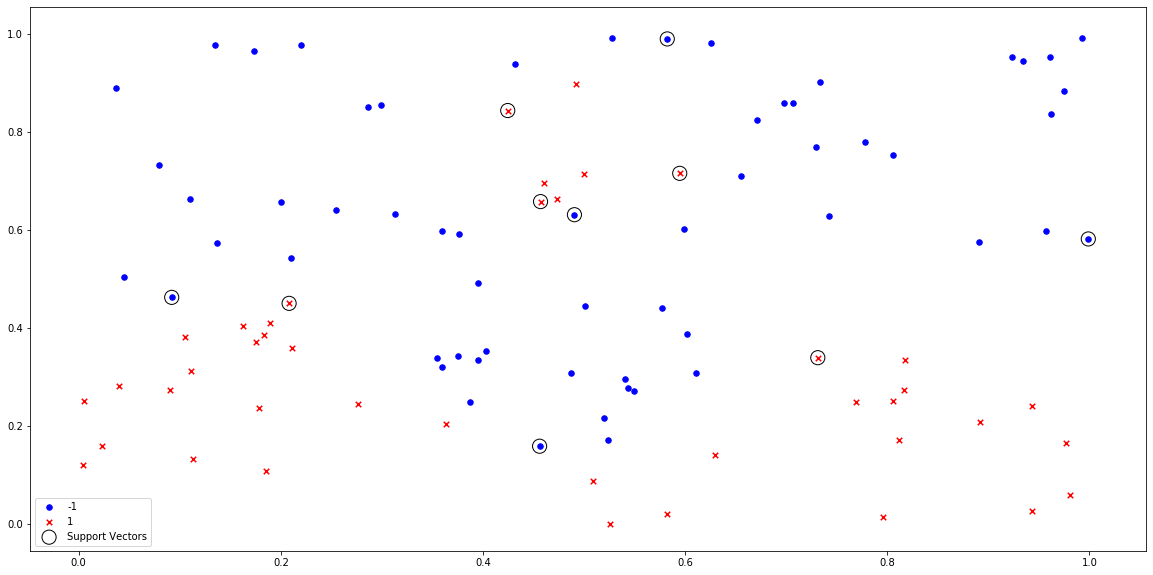

In [73]:
fig, ax = mp.subplots(figsize = (20,10))
cdict = {1: 'red', -1: 'blue'}
markers = {1:'x', -1:'o'}
for g in np.unique(d):
    ix = np.where(d == g)
    ax.scatter(x[:,0][ix], x[:,1][ix], c = cdict[g],marker = markers[g],label = g, s = 30)
    
support_vectors = x[sv]
ax.scatter(support_vectors[:,0], support_vectors[:,1], s=200, facecolors='none', edgecolors='black', label = "Support Vectors")
ax.legend(loc='lower left')

# Finding the three hyperplanes

In [74]:
def decision_function(x, y):
    p =[]
    for i in x:
        for j in y:
            p.append(kernel(i,j))
    return np.array(p).reshape(x.shape[0], y.shape[0])
            

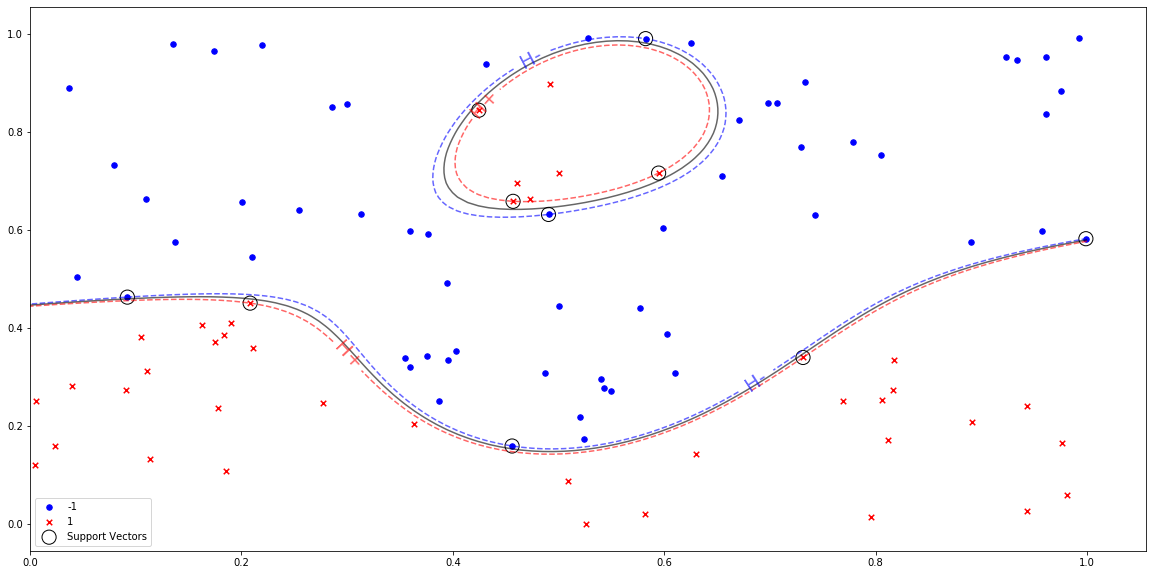

In [76]:
xx =  np.linspace(0,1,100)
yy = np.linspace(0,1,100)
XX, YY = np.meshgrid(xx, yy)
# print(XX.shape)
xy = np.c_[XX.ravel(), YY.ravel()]
#print(xy)

df = decision_function(x,xy)
#print(((alphas*d).reshape(1,XX.shape[0])).dot(kxy))
Z = ((((alphas*d).reshape(1,XX.shape[0])).dot(df)) +b).reshape(XX.shape)

fig, ax = mp.subplots(figsize = (20,10))
contour  = ax.contour(XX, YY, Z, colors=['blue', 'black', 'red'], levels = [-1,0,1], alpha = 0.6, linestyles = ['--','-','--'])

fmt = {}
strs = ['H-', 'H', 'H+']
for l, s in zip(contour.levels, strs):
    fmt[l] = s

# Label every other level using strings
ax.clabel(contour, contour.levels[::2], inline = True,inline_spacing = 10, fmt=fmt, fontsize=20)



cdict = {1: 'red', -1: 'blue'}
markers = {1:'x', -1:'o'}
for g in np.unique(d):
    ix = np.where(d == g)
    ax.scatter(x[:,0][ix], x[:,1][ix], c = cdict[g],marker = markers[g],label = g, s = 30)

# ax.scatter(x[:,0], x[:,1], c= colors, s=10, label = ('blue'))
# ax.scatter(x[:,0], x[:,1], c= colors, s=10, label = ('red'))

# ax.legend()
support_vectors = x[sv]
ax.scatter(support_vectors[:,0], support_vectors[:,1], s=200, facecolors='none', edgecolors='black', label = "Support Vectors")
ax.legend(loc='lower left')

In [45]:
# def af(x):
#     if x>= 0:
#         return 1
#     else:
#         return -1

In [ ]:
# def predict(x,y): 

#     f =[]
#     for k in range(len(x)):
#         p =[]
#         for i in range(len(x[0])):
#             q = np.asarray([x[0][i], y[0][i]])
#             sum = 0
#             for j in range(len(x[0])):
#                 r = np.asarray([x[0][j], y[0][j]])
#                 sum += alphas[j] * d[j] * kernel(r.reshape(1,2), q.reshape(1,2))
#             p.append(af(sum+b))
#         f.append(p)
        
#     return np.asarray(f).T
    

In [ ]:
# u = []
# v = []
# for i in range(len(x)):
#     if predict(b, x[i]) == 1:
#         u.append(x[i])
#     elif predict(b,x[i]) == -1:
#         v.append(x[i])
# u = np.asarray(u)
# v = np.asarray(v)

In [119]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn import svm
# from sklearn.datasets import make_blobs


# # we create 40 separable points
# X, y = make_blobs(n_samples=40, centers=2, random_state=6)

# # fit the model, don't regularize for illustration purposes
# clf = svm.SVC(kernel='linear', C=1000)
# clf.fit(X, y)

# plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

# # plot the decision function
# ax = plt.gca()
# xlim = ax.get_xlim()
# ylim = ax.get_ylim()

# # create grid to evaluate model
# xx = np.linspace(xlim[0], xlim[1], 30)
# yy = np.linspace(ylim[0], ylim[1], 30)
# YY, XX = np.meshgrid(yy, xx)
# # print(xx)
# # print(XX)
# # print(o)
# xy = np.vstack([XX.ravel(), YY.ravel()]).T
# Z = clf.decision_function(xy).reshape(XX.shape)
# # print(Z)
# # print(f)

# # plot decision boundary and margins
# ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
#            linestyles=['--', '-', '--'])
# # plot support vectors
# ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
#            linewidth=1, facecolors='none', edgecolors='k')
# plt.show()

<Figure size 432x288 with 0 Axes>

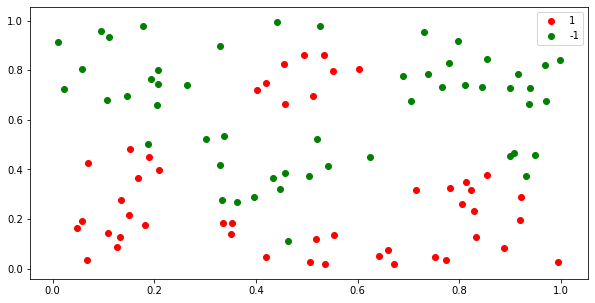

100
100   2
     pcost       dcost       gap    pres   dres
 0: -5.8023e+01 -1.6095e+02  4e+02  1e+01  3e+00
 1: -2.1511e+02 -3.7342e+02  2e+02  8e+00  1e+00
 2: -2.8643e+02 -4.6918e+02  3e+02  8e+00  1e+00
 3: -7.0534e+02 -9.1097e+02  3e+02  6e+00  1e+00
 4: -8.7225e+02 -1.0980e+03  3e+02  6e+00  1e+00
 5: -2.1930e+03 -2.5782e+03  4e+02  6e+00  1e+00
 6: -2.4712e+03 -2.8821e+03  5e+02  6e+00  1e+00
 7: -7.4531e+03 -8.2415e+03  9e+02  6e+00  1e+00
 8: -1.9513e+04 -2.1573e+04  2e+03  5e+00  1e+00
 9: -3.7224e+04 -4.1491e+04  4e+03  5e+00  1e+00
10: -6.4324e+04 -7.3624e+04  1e+04  5e+00  1e+00
11: -1.1516e+05 -1.3864e+05  2e+04  4e+00  8e-01
12: -1.7555e+05 -2.1622e+05  4e+04  3e+00  6e-01
13: -2.1054e+05 -2.3839e+05  3e+04  1e+00  2e-01
14: -2.0943e+05 -2.3613e+05  3e+04  9e-01  2e-01
15: -2.0649e+05 -2.2654e+05  2e+04  4e-01  7e-02
16: -2.1523e+05 -2.1603e+05  8e+02  1e-02  3e-03
17: -2.1549e+05 -2.1554e+05  5e+01  1e-04  2e-05
18: -2.1553e+05 -2.1553e+05  6e-01  1e-06  2e-07
19: -2.15

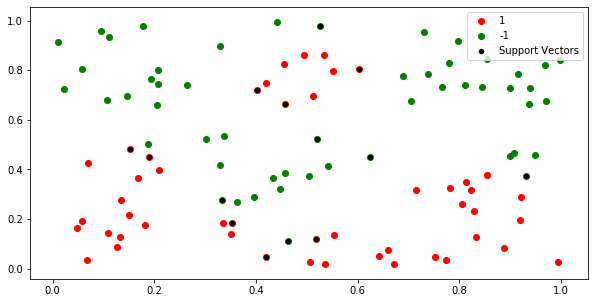

bias  [136.85060421485105, 136.85060421493836, 136.85060421482194, 136.85060421482194, 136.85060421485105, 136.85060421470553, 136.85060421488015, 136.85060421476373, 136.85060421470553, 136.46587568349787, 136.85060421488015, 135.4785094743129, 136.4573317343311, 136.85060421493836]
bias_avg  136.69702594680712


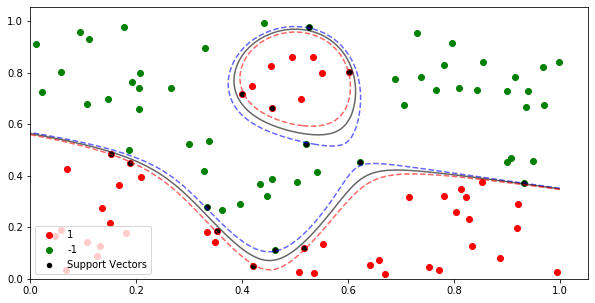

In [25]:
import matplotlib.pyplot as plt 
import numpy as np
import random as rd
import math
import cvxopt
import cvxopt.solvers as solvers
np.random.seed(100)


def polynomial_kernel(x, y):
    p = 4
    return (1 + x[0]*y[0]+x[1]*y[1]) ** p

input_size = 100
X = [rd.uniform(0,1) for i in range(input_size*2)]
X = np.array(X).reshape(input_size, 2)
#print(X)

plt.clf()
d = []
colors =[]
alpha_precision = 1e-5
plot_x_p = []
plot_y_p = []
plot_x_n = []
plot_y_n = []
for i in range(input_size):
    if (X[i][1] < ((1/5)*np.sin(10*X[i][0]) + 0.3)) or ((X[i][1] - 0.8)**2 + (X[i][0] - 0.5)**2) < (0.0225):
        d.append(1)
        colors.append('r')
        
        plot_x_p.append(X[i][0])
        plot_y_p.append(X[i][1])
    else :
        d.append(-1)
        colors.append('b')
        plot_x_n.append(X[i][0])
        plot_y_n.append(X[i][1])
        
#X = np.mat(np.reshape(X,(input_size,2)) ) 
fig, ax = plt.subplots(figsize = (10,5))
ax.scatter(plot_x_p,plot_y_p,color = 'red', label = '1')
ax.scatter(plot_x_n,plot_y_n,color = 'green', label = '-1') 
ax.legend()
plt.show()   
print(len(d))
y = np.array(d)
y =  y.astype('float')

n_samples, n_features = len(X),len(X[0])
print(n_samples,' ',n_features)
# Gram matrix
K = np.zeros((n_samples, n_samples))
for i in range(n_samples):
    for j in range(n_samples):
#        print(X[i])
        K[i,j] = polynomial_kernel(X[i], X[j])
#print('k ',K)   
y_matrix = y.reshape(1, -1) * 1.
#print('dot ',np.dot(y_matrix.T, y_matrix))
#print('matmul ',np.matmul(y_matrix.T, y_matrix))
H = np.matmul(y_matrix.T, y_matrix) * K
#print('H ',H)
P = cvxopt.matrix(H)
#print('P ',P)
q = cvxopt.matrix(-np.ones((n_samples, 1)))
G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
h = cvxopt.matrix(np.zeros(n_samples))
A = cvxopt.matrix(y_matrix)
b = cvxopt.matrix(np.zeros(1))
#    
solvers.options['abstol'] = 1e-10
solvers.options['reltol'] = 1e-10
solvers.options['feastol'] = 1e-10

solution = solvers.qp(P, q, G, h, A, b)

a =  np.ravel(solution['x'])
alphas_list = a.copy()
print('alphas_list ',alphas_list)
# Support vectors have non zero lagrange multipliers
temp = a.copy()
temp.sort()
#print('a_sort ', temp)
alpha_precision = temp[85]
print(alpha_precision)
sv = a > alpha_precision
#print('sv ',sv)
ind = []
plot_x_sv = []
plot_y_sv = []
for  i in range(n_samples):
    if(sv[i]):
        plot_x_sv.append(X[i][0])
        plot_y_sv.append(X[i][1])
        ind.append(i)
#print('ind ',ind)        
a = a[sv]
#print('a_after ',a)
print("%d support vectors out of %d points" % (len(a), n_samples))
sv_x = X[sv]

#print('sv ',sv)
sv_y = y[sv]
fig, ax = plt.subplots(figsize = (10,5))
ax.scatter(plot_x_p,plot_y_p,color = 'red', label = '1')
ax.scatter(plot_x_n,plot_y_n,color = 'green', label = '-1')
ax.scatter(plot_x_sv,plot_y_sv, s=20, color ='black',label = "Support Vectors")
ax.legend()
plt.show()
# Intercept
bias = []
for i in range(len(a)):
    s= 0
    for j in range(len(alphas_list)):
        s += alphas_list[j]*d[j]*polynomial_kernel(X[j],X[ind[i]])
#        print(sum)
    bias.append(d[ind[i]]-s)
    
print('bias ',bias)  

bias_avg = np.mean(np.array(bias)) 
print('bias_avg ',bias_avg)


#plotting hyperplanes
xx =  np.linspace(0,1,100)
yy = np.linspace(0,1,100)
XX, YY = np.meshgrid(xx, yy)
xy = np.c_[XX.ravel(), YY.ravel()]
#print('len(xy) ', len(xy))

p =[]
for i in X:
    for j in xy:
        p.append(polynomial_kernel(i,j))
df = np.array(p).reshape(len(X), xy.shape[0])
#print('len(df) ',len(df),' len(df[0]) ',len(df[0]))
#print('XX.shape[0] ',XX.shape[0])
Z = ((((alphas_list*d).reshape(1,XX.shape[0])).dot(df)) +bias_avg).reshape(XX.shape)
#print('Z ',Z)
fig, ax = plt.subplots(figsize = (10,5))
ax.contour(XX, YY, Z, colors=['blue', 'black', 'red'], levels = [-1,0,1], alpha = 0.6, linestyles = ['--','-','--'])


# fmt = {}
# strs = ['H-', 'H', 'H+']
# for l, s in zip(contour.levels, strs):
#     fmt[l] = s

# # Label every other level using strings
# plt.clabel(contour, contour.levels[::2], inline = True,inline_spacing = 10, fmt=fmt, fontsize=20)



# spr = {1: 'red', -1: 'blue'}
# m = {1:'^', -1:'o'}
# #print('d ',d)
# for g in np.unique(d):
#     ix = np.where(d == g)
#     print('ix ',ix)
ax.scatter(plot_x_p,plot_y_p,color = 'red', label = '1')
ax.scatter(plot_x_n,plot_y_n,color = 'green', label = '-1')

support_vectors = X[sv]
ax.scatter(plot_x_sv,plot_y_sv, s=20, color ='black',label = "Support Vectors")
ax.legend(loc='lower left')



<Figure size 432x288 with 0 Axes>

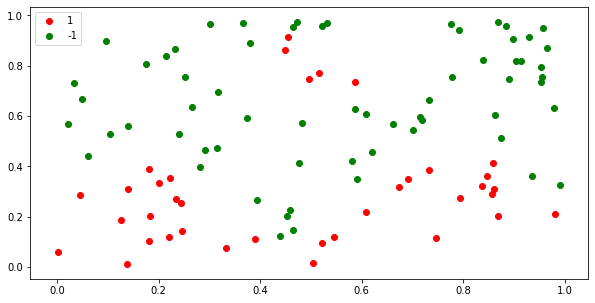

100
100   2
     pcost       dcost       gap    pres   dres
 0: -5.4647e+01 -1.5517e+02  3e+02  1e+01  3e+00
 1: -2.0272e+02 -3.4133e+02  2e+02  6e+00  2e+00
 2: -5.6466e+02 -7.1021e+02  2e+02  5e+00  1e+00
 3: -7.4903e+02 -9.1779e+02  2e+02  5e+00  1e+00
 4: -2.5577e+03 -2.8923e+03  4e+02  4e+00  1e+00
 5: -3.5307e+03 -3.9604e+03  5e+02  4e+00  1e+00
 6: -1.0921e+04 -1.2071e+04  1e+03  4e+00  1e+00
 7: -2.2033e+04 -2.4285e+04  2e+03  4e+00  1e+00
 8: -4.4338e+04 -4.9241e+04  5e+03  4e+00  1e+00
 9: -8.1749e+04 -9.2242e+04  1e+04  4e+00  1e+00
10: -1.1903e+05 -1.3659e+05  2e+04  4e+00  1e+00
11: -2.1597e+05 -2.5982e+05  4e+04  3e+00  8e-01
12: -3.4212e+05 -4.1866e+05  8e+04  2e+00  5e-01
13: -3.8857e+05 -4.1432e+05  3e+04  3e-01  9e-02
14: -3.8976e+05 -3.9144e+05  2e+03  2e-02  5e-03
15: -3.8989e+05 -3.8992e+05  3e+01  3e-04  6e-05
16: -3.8990e+05 -3.8990e+05  3e-01  3e-06  6e-07
17: -3.8990e+05 -3.8990e+05  3e-03  3e-08  6e-09
18: -3.8990e+05 -3.8990e+05  3e-05  3e-10  4e-10
19: -3.89

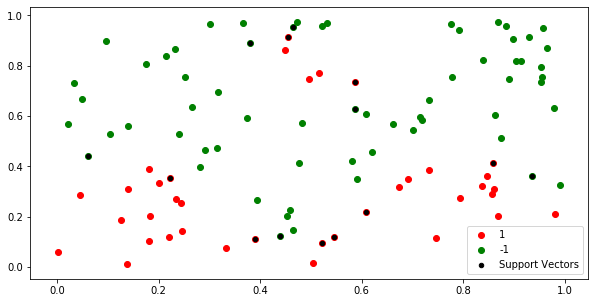

bias  [89.88201150193345, 89.88201150170062, 89.88201150193345, 89.88201150181703, 89.88201150175883, 89.88201150135137, 89.88201150193345, 89.88201150184614, 89.88201150193345, 89.88201150187524, 89.87106078444049, 89.88201150187524, 89.88201150196255, 89.88201150216628]
bias_avg  89.88122930775197


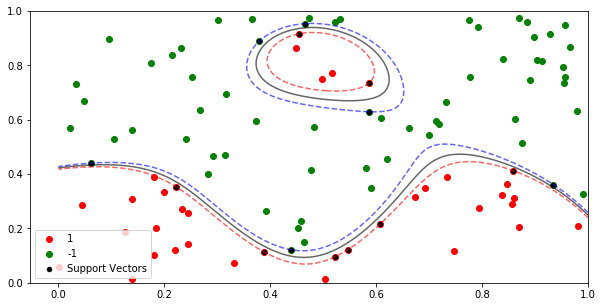

In [30]:
import matplotlib.pyplot as plt 
import numpy as np
import random as rd
import math
import cvxopt
import cvxopt.solvers as solvers
np.random.seed(100)


def polynomial_kernel(x, y):
    p = 4
    return (1 + x[0]*y[0]+x[1]*y[1]) ** p

input_size = 100
X = [rd.uniform(0,1) for i in range(input_size*2)]
X = np.array(X).reshape(input_size, 2)
#print(X)

plt.clf()
d = []
colors =[]
alpha_precision = 1e-5
plot_x_p = []
plot_y_p = []
plot_x_n = []
plot_y_n = []
for i in range(input_size):
    if (X[i][1] < ((1/5)*np.sin(10*X[i][0]) + 0.3)) or ((X[i][1] - 0.8)**2 + (X[i][0] - 0.5)**2) < (0.0225):
        d.append(1)
        colors.append('r')
        
        plot_x_p.append(X[i][0])
        plot_y_p.append(X[i][1])
    else :
        d.append(-1)
        colors.append('b')
        plot_x_n.append(X[i][0])
        plot_y_n.append(X[i][1])
        
#X = np.mat(np.reshape(X,(input_size,2)) ) 
fig, ax = plt.subplots(figsize = (10,5))
ax.scatter(plot_x_p,plot_y_p,color = 'red', label = '1')
ax.scatter(plot_x_n,plot_y_n,color = 'green', label = '-1') 
ax.legend()
plt.show()   
print(len(d))
y = np.array(d)
y =  y.astype('float')

n_samples, n_features = len(X),len(X[0])
print(n_samples,' ',n_features)
# Gram matrix
K = np.zeros((n_samples, n_samples))
for i in range(n_samples):
    for j in range(n_samples):
#        print(X[i])
        K[i,j] = polynomial_kernel(X[i], X[j])
#print('k ',K)   
y_matrix = y.reshape(1, -1) * 1.
#print('dot ',np.dot(y_matrix.T, y_matrix))
#print('matmul ',np.matmul(y_matrix.T, y_matrix))
H = np.matmul(y_matrix.T, y_matrix) * K
#print('H ',H)
P = cvxopt.matrix(H)
#print('P ',P)
q = cvxopt.matrix(-np.ones((n_samples, 1)))
G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
h = cvxopt.matrix(np.zeros(n_samples))
A = cvxopt.matrix(y_matrix)
b = cvxopt.matrix(np.zeros(1))
#    
solvers.options['abstol'] = 1e-10
solvers.options['reltol'] = 1e-10
solvers.options['feastol'] = 1e-10

solution = solvers.qp(P, q, G, h, A, b)

a =  np.ravel(solution['x'])
alphas_list = a.copy()
print('alphas_list ',alphas_list)
# Support vectors have non zero lagrange multipliers
temp = a.copy()
temp.sort()
#print('a_sort ', temp)
alpha_precision = temp[85]
print(alpha_precision)
sv = a > alpha_precision
#print('sv ',sv)
ind = []
plot_x_sv = []
plot_y_sv = []
for  i in range(n_samples):
    if(sv[i]):
        plot_x_sv.append(X[i][0])
        plot_y_sv.append(X[i][1])
        ind.append(i)
#print('ind ',ind)        
a = a[sv]
#print('a_after ',a)
print("%d support vectors out of %d points" % (len(a), n_samples))
sv_x = X[sv]

#print('sv ',sv)
sv_y = y[sv]
fig, ax = plt.subplots(figsize = (10,5))
ax.scatter(plot_x_p,plot_y_p,color = 'red', label = '1')
ax.scatter(plot_x_n,plot_y_n,color = 'green', label = '-1')
ax.scatter(plot_x_sv,plot_y_sv, s=20, color ='black',label = "Support Vectors")
ax.legend()
plt.show()
# Intercept
bias = []
for i in range(len(a)):
    s= 0
    for j in range(len(alphas_list)):
        s += alphas_list[j]*d[j]*polynomial_kernel(X[j],X[ind[i]])
#        print(sum)
    bias.append(d[ind[i]]-s)
    
print('bias ',bias)  

bias_avg = np.mean(np.array(bias)) 
print('bias_avg ',bias_avg)


#plotting hyperplanes
xx =  np.linspace(0,1,100)
yy = np.linspace(0,1,100)
XX, YY = np.meshgrid(xx, yy)
xy = np.c_[XX.ravel(), YY.ravel()]
#print('len(xy) ', len(xy))

p =[]
for i in X:
    for j in xy:
        p.append(polynomial_kernel(i,j))
df = np.array(p).reshape(len(X), xy.shape[0])
#print('len(df) ',len(df),' len(df[0]) ',len(df[0]))
#print('XX.shape[0] ',XX.shape[0])
Z = ((((alphas_list*d).reshape(1,XX.shape[0])).dot(df)) +bias_avg).reshape(XX.shape)
#print('Z ',Z)
fig, ax = plt.subplots(figsize = (10,5))
ax.contour(XX, YY, Z, colors=['blue', 'black', 'red'], levels = [-1,0,1], alpha = 0.6, linestyles = ['--','-','--'])


ax.scatter(plot_x_p,plot_y_p,color = 'red', label = '1')
ax.scatter(plot_x_n,plot_y_n,color = 'green', label = '-1')

support_vectors = X[sv]
ax.scatter(plot_x_sv,plot_y_sv, s=20, color ='black',label = "Support Vectors")
ax.legend(loc='lower left')

